# Bead segmentation and measurements
This notebook shows how to detect hot spots / local maxima / beads in an image and how to measure their FWHM. To make the algorithm work, the beads should be sufficiently sparse.

In [1]:
import pyclesperanto_prototype as cle

cle.get_device()

<Intel(R) Iris(R) Xe Graphics on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

Let's start by making an image showing local maxima.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
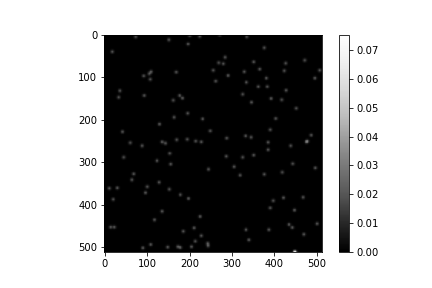
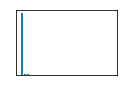

In [2]:
import numpy as np
from skimage.io import imshow

random_image = np.random.random([512,512])
binary_image = random_image > 0.9995

# push to GPU
input_image = cle.push(binary_image * random_image)

# blur the image
sigma = 3
starting_point = cle.gaussian_blur(input_image, sigma_x=sigma, sigma_y=sigma)

# show input image
starting_point

## Local maxima detection

cl.OCLArray([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
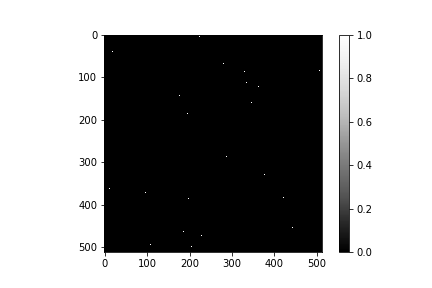
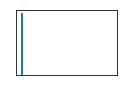

In [3]:
maxima = cle.detect_maxima_box(starting_point)
maxima

## Local threshold determination

In [4]:
# Label maxima
labeled_maxima = cle.label_spots(maxima)

# read out intensities at the maxima
max_intensities = cle.read_intensities_from_map(labeled_maxima, starting_point)
print(max_intensities)

# calculate thresholds
thresholds = cle.multiply_image_and_scalar(max_intensities, scalar=0.5)
print(thresholds)

[[0.         0.         0.07530212 0.01768412 0.01768251 0.01768345
  0.01768355 0.01767614 0.01768117 0.01768287 0.01767613 0.01767726
  0.0176767  0.01767617 0.01770093 0.01768188 0.01769348 0.01768091
  0.01768291 0.01767742 0.01767924 0.01767959 0.02023154 0.01767629
  0.02023292 0.01767845 0.01767934 0.01768218 0.01767849 0.01767824
  0.01768037 0.01767676 0.01767627 0.01768442 0.01767656 0.01768143
  0.01768095 0.01768311 0.01783455 0.01767915 0.01783821 0.01768428
  0.01767994 0.01768341 0.01767852 0.01768236 0.01768361 0.0176807
  0.01768154 0.01767861 0.01767618 0.01767758 0.0176818  0.01768077
  0.01767783 0.01768455 0.01768431 0.01767913 0.01767841 0.01768026
  0.01768074 0.03163752 0.01798327 0.01768441 0.01768178 0.01767889
  0.01798355 0.01768068 0.01768451 0.01768157 0.01767765 0.01768141
  0.01768202 0.01767992 0.01768101 0.01767624 0.01768075 0.01768441
  0.01768228 0.01768184 0.01767698 0.01768225 0.01768155 0.01767988
  0.01767623 0.01768425 0.01768363 0.01767961 0.0

## Make a local threshold image

cl.OCLArray([[  1,   1,   1, ...,  12,  12,  12],
       [  1,   1,   1, ...,  12,  12,  12],
       [  1,   1,   1, ...,  12,  12,  12],
       ...,
       [106, 106, 106, ..., 112, 112, 112],
       [106, 106, 106, ..., 112, 112, 112],
       [106, 106, 106, ..., 112, 112, 112]], dtype=uint32)
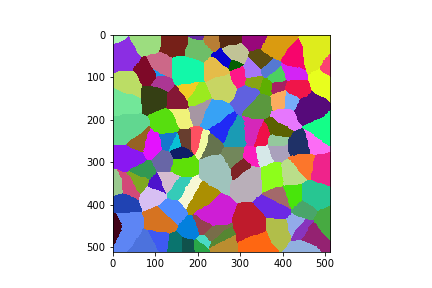

In [5]:
# Extend labeled maxima until they touch
voronoi_label_image = cle.extend_labeling_via_voronoi(labeled_maxima)
voronoi_label_image

cl.OCLArray([[0.        , 0.        , 0.        , ..., 0.00883835, 0.00883835,
        0.00883835],
       [0.        , 0.        , 0.        , ..., 0.00883835, 0.00883835,
        0.00883835],
       [0.        , 0.        , 0.        , ..., 0.00883835, 0.00883835,
        0.00883835],
       ...,
       [0.00893709, 0.00893709, 0.00893709, ..., 0.00883822, 0.00883822,
        0.00883822],
       [0.00893709, 0.00893709, 0.00893709, ..., 0.00883822, 0.00883822,
        0.00883822],
       [0.00893709, 0.00893709, 0.00893709, ..., 0.00883822, 0.00883822,
        0.00883822]], dtype=float32)
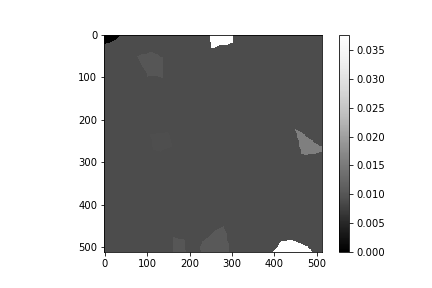
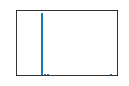

In [6]:
# Replace labels with thresholds
threshold_image = cle.replace_intensities(voronoi_label_image, thresholds)
threshold_image

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
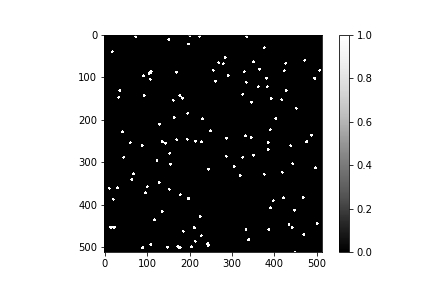
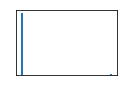

In [7]:
# Apply threshold
binary_segmented = cle.greater(starting_point, threshold_image)
binary_segmented

## Measure bounding boxes

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
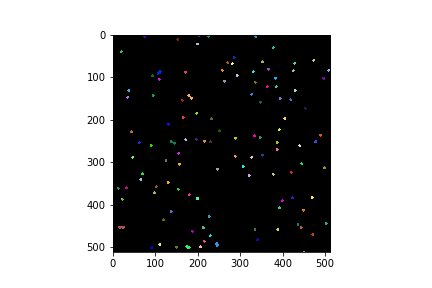

In [8]:
# Label objects
labels = cle.connected_components_labeling_box(binary_segmented)
labels

In [9]:
# Derive statistics
stats = cle.statistics_of_labelled_pixels(label_image=labels)

print('Bounding box widths', stats['bbox_width'])
print('Bounding box heights', stats['bbox_height'])

Bounding box widths [ 7. 16.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7. 11.  7.  7.  7.  7.  7.  7. 15.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7. 13. 14.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.]
Bounding box heights [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7. 12.  7.  7.  7.  7.  7.  7. 10.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  9. 13.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7. 13.  7.  7.  7.  7.  7.  3.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  3.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.]


The bounding box width and height should be approximately twice as large as the sigma used for bluring the image at the very beginning.

In [10]:
print("Sigma", sigma)

Sigma 3
